ode model.  
5. Forecast the predictions for next 5 years on  target variable.

In [29]:
import pandas as pd
import numpy as np

import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [62]:
df = pd.read_csv("C:\\Datasets\\AirPassengers.csv", index_col=["Month"])
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [64]:
df.index=pd.to_datetime(df.index)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### 1. Comment on the nature of the data using suitable visualization techniques

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

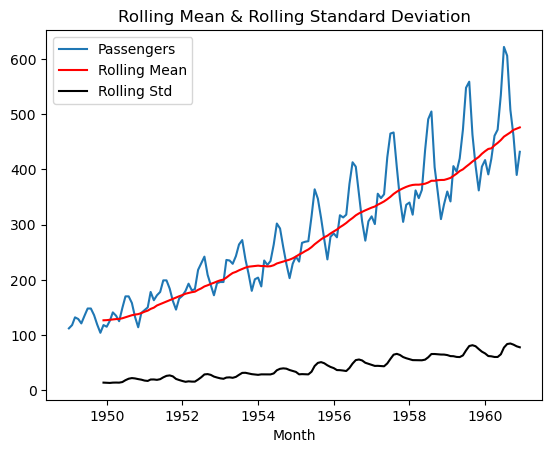

In [31]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
sns.lineplot(data=df)
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

- Continues Increase in Mean and Standard Deviation with time in data

####  2. Check the stationary using ADF test and autocorrelation plot.

In [35]:
test_result=adfuller(df['Passengers'])

In [41]:
test_result

(0.8153688792060597,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [37]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [39]:
adfuller_test(df['Passengers'])

ADF Test Statistic : 0.8153688792060597
p-value : 0.9918802434376411
#Lags Used : 13
Number of Observations Used : 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [66]:
# first difference
df['diff'] = df['Passengers'] - df['Passengers'].shift(1)
#test_stationarity(df['diff'].dropna(inplace=False))

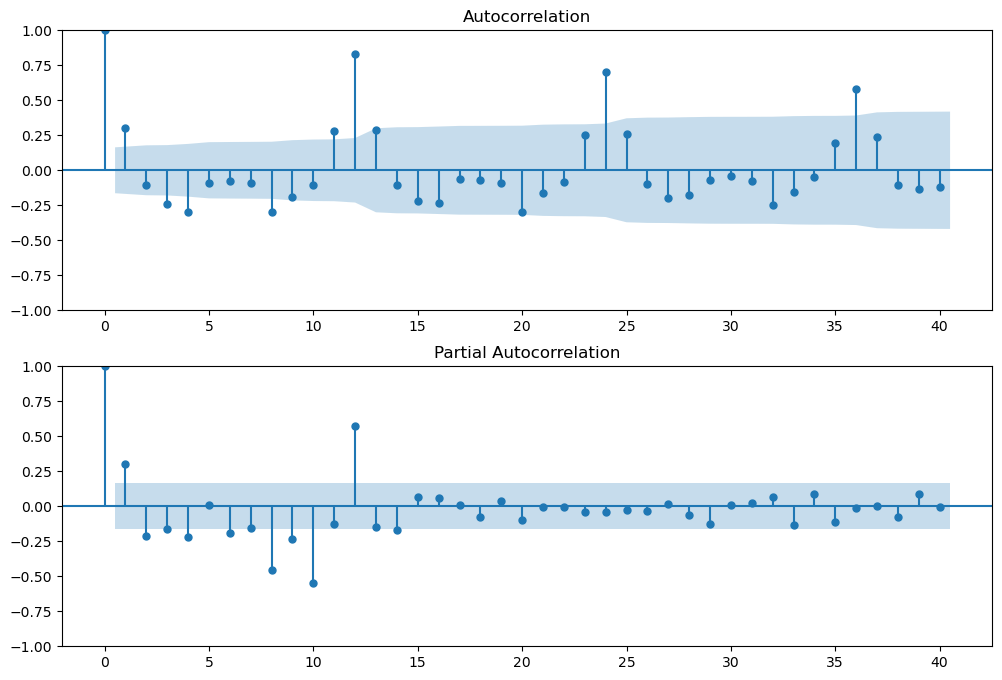

In [49]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['diff'][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['diff'][1:], lags=40, ax=ax2)

In [68]:
df["Seasonal"] = df["Passengers"] - df["Passengers"].shift(12)
df.head(14)

,Passengers,diff,Seasonal
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,NaN
1949-04-01,129,-3.0,NaN
1949-05-01,121,-8.0,NaN
1949-06-01,135,14.0,NaN
1949-07-01,148,13.0,NaN
1949-08-01,148,0.0,NaN
1949-09-01,136,-12.0,NaN


<Axes: xlabel='Month', ylabel='Seasonal'>

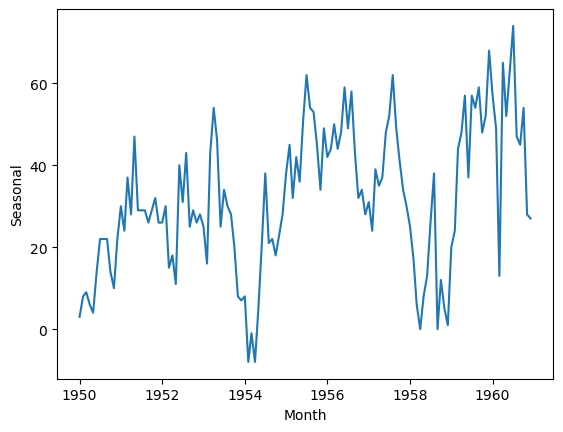

In [54]:
sns.lineplot(data=df["Seasonal"])

In [56]:
## Again test dickey fuller test
adfuller_test(df['Seasonal'].dropna())

ADF Test Statistic : -3.3830207264924805
p-value : 0.011551493085514982
#Lags Used : 1
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### 3. Forecast the target variable prediction using a suitable type of model.

In [72]:
import warnings

warnings.filterwarnings("ignore")

In [74]:
# Creating ARIMA model
model = sm.tsa.arima.ARIMA(df['Passengers'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Wed, 27 Nov 2024   AIC                           1394.683
Time:                        20:15:57   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.000     751.362    1172.492
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 2.14
Prob(Q):                              0.65   Prob(JB):                         0.34
Heteroskedasticity (H):               7.00   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

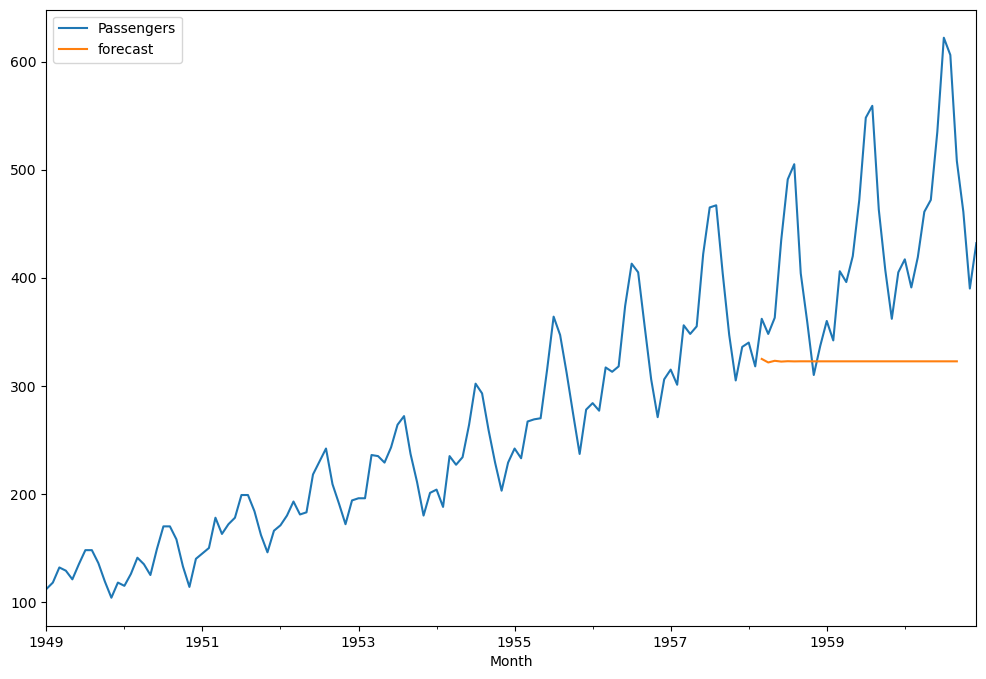

In [76]:
df['forecast']=model_fit.predict(start=110,end=140,dynamic=True)
df[['Passengers','forecast']].plot(figsize=(12,8))

- Arima Alone was not able to find the pattern need to add seasonality in it

#### SARIMAX

In [79]:
model=sm.tsa.statespace.SARIMAX(df['Passengers'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

<Axes: xlabel='Month'>

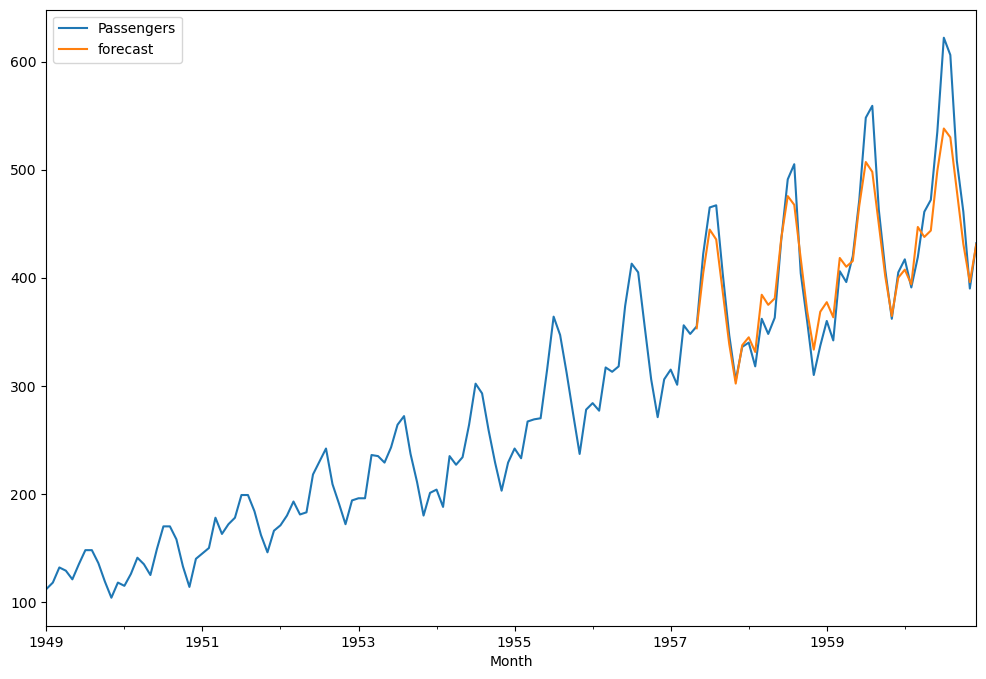

In [83]:
df['forecast']=results.predict(start=100,end=144,dynamic=True)
df[['Passengers','forecast']].plot(figsize=(12,8))

#### 4. Evaluate the different types of error residues to check fitness of good of the  model.

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [93]:
y_true = df['Passengers']
y_pred = results.fittedvalues

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 10.04080588740737
MSE: 241.9833586970869
RMSE: 15.555814305174993


#### 5. Forecast the Predictions for the Next 5 Years on Target Variable

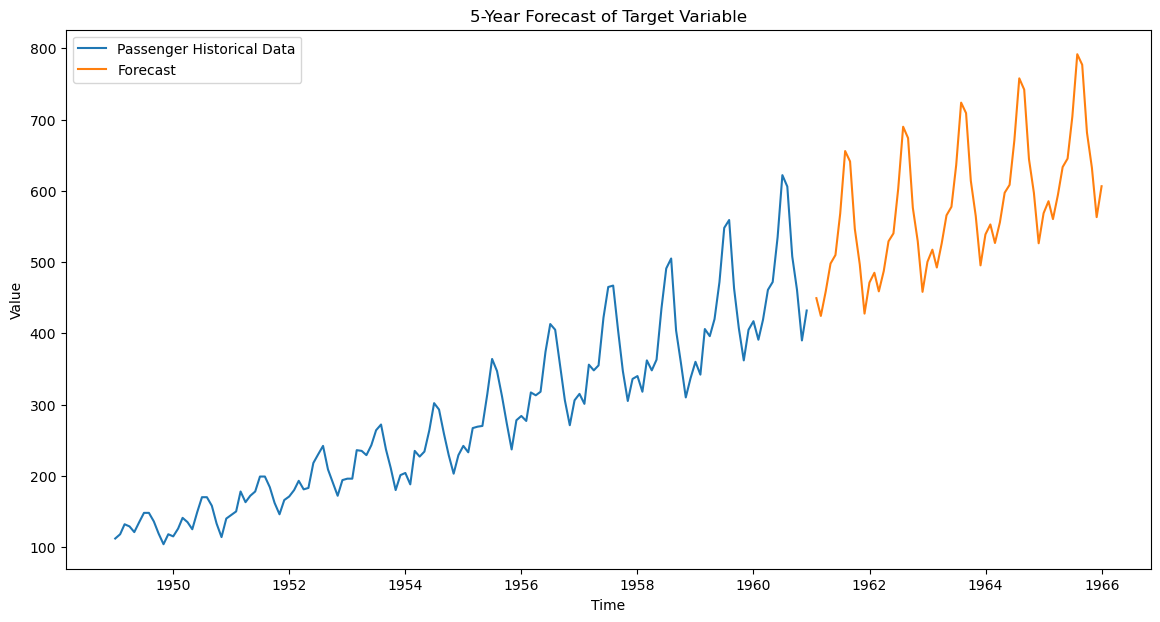

In [95]:
# Forecasting for the next 5 years (assuming monthly data, steps=60)
forecast = results.forecast(steps=60)
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["Passengers"], label='Passenger Historical Data')
plt.plot(pd.date_range(start=df.index[-1], periods=61, freq='M')[1:], forecast, label='Forecast')
plt.title('5-Year Forecast of Target Variable')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()